# Subscriptions API - Data Collection Delivery

This notebook demonstrates using the hosting block in the Subscriptions API. It should take approximately 20 minutes to complete. It is divided into two sections.

- Creating PlanetScope subscriptions and delivering data to Sentinel Hub
  - Creating the Subscription payloads
  - Submitting the payload to create the subscriptions
  - Checking the status of Subscriptions
- Using the data that was delivered to calculate statistics and create visualizations
  - Creating NDVI time series and filtering out cloudy images
  - Requesting true color imagery over cloud free days
  - Performing multi-temporal analysis by caclulating the median NDVI from cloud-free images

In [ ]:
from datetime import datetime, timezone, timedelta
from pprint import pprint
import geopandas as gpd
import pandas as pd
import numpy as np
import asyncio
import json
import copy
import os
import re
import planet
from planet.clients.subscriptions import SubscriptionsClient

from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    MimeType,
)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# 1) Create PlanetScope Subscriptions Delivering to a Data Collection

First, we need to order PlanetScope data. Here we will use the Subscriptions API to order the data and deliver it to a data collection. 

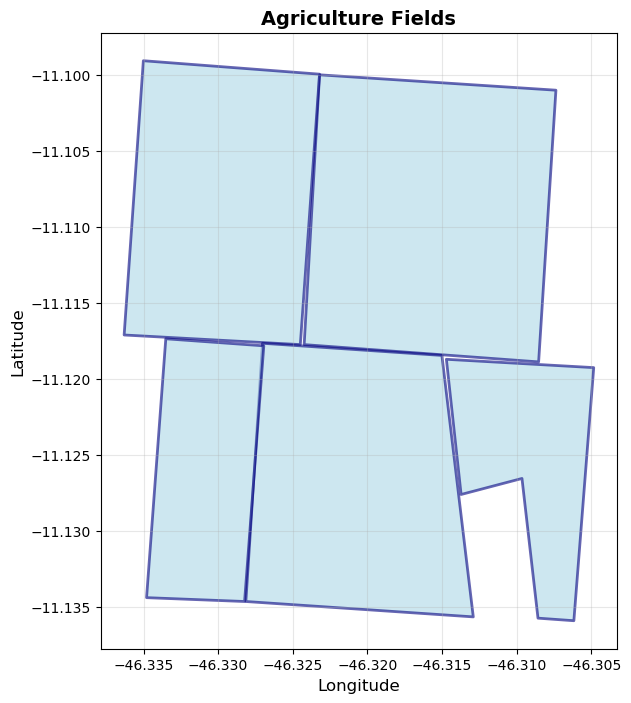

In [54]:
# load a geojson into a map to view where we will be creating subscriptions

# Read the fields from a GeoJSON
agriculture_fields_geojson = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"id":2,"geometry":{"type":"Polygon","coordinates":[[[-46.323209,-11.099955],[-46.324496,-11.117731],[-46.336298,-11.117099],[-46.335011,-11.099071],[-46.323209,-11.099955]]]}},{"type":"Feature","properties":{},"id":1,"geometry":{"type":"Polygon","coordinates":[[[-46.323209,-11.099997],[-46.307373,-11.101008],[-46.308532,-11.118868],[-46.324239,-11.117731],[-46.323209,-11.099997]]]}},{"type":"Feature","properties":{},"id":3,"geometry":{"type":"Polygon","coordinates":[[[-46.328144,-11.134617],[-46.327028,-11.117643],[-46.315012,-11.118443],[-46.312909,-11.135628],[-46.328144,-11.134617]]]}},{"type":"Feature","properties":{},"id":4,"geometry":{"type":"Polygon","coordinates":[[[-46.333508,-11.117348],[-46.326942,-11.117811],[-46.32823,-11.134617],[-46.334796,-11.134364],[-46.333508,-11.117348]]]}},{"type":"Feature","properties":{},"id":5,"geometry":{"type":"Polygon","coordinates":[[[-46.314712,-11.118696],[-46.304841,-11.119243],[-46.306171,-11.13588],[-46.308575,-11.135712],[-46.309648,-11.12653],[-46.313725,-11.127583],[-46.314712,-11.118696]]]}}]}'

agriculture_fields = gpd.read_file(agriculture_fields_geojson)

agriculture_fields.plot(
    figsize=(10, 8),
    color='lightblue',
    edgecolor='navy',
    linewidth=2,
    alpha=0.6,
)

plt.title('Agriculture Fields', fontsize=14, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 1) Creating PlanetScope subscriptions and delivering data to Sentinel Hub

Here we can use the input field boundaries to create new PlanetScope subscriptions.  We will iterate over each feature in the feature collection and create a subscription.

In [7]:
# OAuth2 python client authentication
# If you are not already logged in, this will prompt you to open a web browser to log in.
auth = planet.Auth.from_profile('planet-user', save_state_to_storage=False)
if not auth.is_initialized():
    auth.user_login(allow_open_browser=False, allow_tty_prompt=True)

session = planet.Session(auth)
pl = planet.Planet(session)

Please activate your client.
Visit the activation site:

	https://login.planet.com/activate?user_code=QHQC-BRMQ

and confirm the authorization code:

	QHQC-BRMQ



2025-09-25 21:46:09,705 - INFO - Session read timeout set to 125.0 seconds.


In [37]:
# Set up variables for creating the subscriptions

# Define a start and end time
start_time = datetime(2022, 6, 1, tzinfo=timezone.utc)
end_time = datetime(2023, 6, 1, tzinfo=timezone.utc)

# Set a collection ID, or set it to None and the function will a create a new collection
collection_id = None # "insert-collection-id-for-pre-existing"

# Create variable to name the subscriptions
base_subscription_name = 'agriculture_subscriptions'

# Incrementor to count the number of subscriptions created
incrementor = 1

In [9]:
# List of subscriptions created
subscriptions = []

async with planet.Session(auth=auth) as sess:

    cl = SubscriptionsClient(sess)

    #For each feature in our geojson feature collection
    for feature in agriculture_fields['features']:

        # Create a name for the subscription
        subscription_name = f"{base_filename}_{incrementor}_PlanetScope"
        
        # Build the subscription payload
        payload = planet.subscription_request.build_request(
            name=subscription_name,
            source=planet.subscription_request.catalog_source(
                start_time=start_time,
                end_time=end_time,
                item_types=["PSScene"],
                asset_types=["ortho_analytic_8b_sr", "ortho_analytic_8b_xml", "ortho_udm2"],
                geometry=feature['geometry'],
            ),
            hosting=planet.subscription_request.sentinel_hub(collection_id=collection_id),
        )
        
        # Create the subscription
        results = await cl.create_subscription(payload)
        subscription_id = results["id"]
        subscriptions.append(subscription_id)
        
        # If no collection ID is set, set the collection ID as the collection created for the first subscription that is created
        if not collection_id:
            results = await cl.get_subscription(subscription_id=subscriptions[0])
            collection_id = results["hosting"]["parameters"]["collection_id"]
            await asyncio.sleep(3) # delay so collection can be established

        incrementor += 1

    print("{} Subscriptions created!".format(len(subscriptions)))

2024-04-10 14:45:02,784 - INFO - Session read timeout set to 30.0.
2024-04-10 14:45:03,207 - INFO - POST https://api.planet.com/subscriptions/v1 - Sent
2024-04-10 14:45:06,460 - INFO - HTTP Request: POST https://api.planet.com/subscriptions/v1 "HTTP/1.1 200 OK"
2024-04-10 14:45:06,460 - INFO - POST https://api.planet.com/subscriptions/v1 - Status 200
2024-04-10 14:45:06,467 - INFO - GET https://api.planet.com/subscriptions/v1/e2a71877-40ae-488a-8d5a-b698bc3b8494 - Sent
2024-04-10 14:45:06,522 - INFO - HTTP Request: GET https://api.planet.com/subscriptions/v1/e2a71877-40ae-488a-8d5a-b698bc3b8494 "HTTP/1.1 200 OK"
2024-04-10 14:45:06,522 - INFO - GET https://api.planet.com/subscriptions/v1/e2a71877-40ae-488a-8d5a-b698bc3b8494 - Status 200
2024-04-10 14:45:09,548 - INFO - POST https://api.planet.com/subscriptions/v1 - Sent
2024-04-10 14:45:11,286 - INFO - HTTP Request: POST https://api.planet.com/subscriptions/v1 "HTTP/1.1 200 OK"
2024-04-10 14:45:11,286 - INFO - POST https://api.planet.c

4 Subscriptions created!


In [19]:
# Check the status of the subscriptions

async with planet.Session(auth=auth) as sess:

    cl = SubscriptionsClient(sess)

    statuses = []

    for subscription_id in subscriptions[:10]:
        sub_details = await cl.get_subscription(subscription_id=subscription_id)
        subscription_status = sub_details["status"]
        statuses.append(f"Subscription ID: {subscription_id} ({subscription_status})")

print("------")
for status in statuses:
    print(status)

2024-04-10 14:56:18,409 - INFO - Session read timeout set to 30.0.
2024-04-10 14:56:18,851 - INFO - GET https://api.planet.com/subscriptions/v1/e2a71877-40ae-488a-8d5a-b698bc3b8494 - Sent
2024-04-10 14:56:18,966 - INFO - HTTP Request: GET https://api.planet.com/subscriptions/v1/e2a71877-40ae-488a-8d5a-b698bc3b8494 "HTTP/1.1 200 OK"
2024-04-10 14:56:18,979 - INFO - GET https://api.planet.com/subscriptions/v1/e2a71877-40ae-488a-8d5a-b698bc3b8494 - Status 200
2024-04-10 14:56:18,985 - INFO - GET https://api.planet.com/subscriptions/v1/9f2e37c7-54d1-4376-b65f-f2d4b2935988 - Sent
2024-04-10 14:56:19,045 - INFO - HTTP Request: GET https://api.planet.com/subscriptions/v1/9f2e37c7-54d1-4376-b65f-f2d4b2935988 "HTTP/1.1 200 OK"
2024-04-10 14:56:19,047 - INFO - GET https://api.planet.com/subscriptions/v1/9f2e37c7-54d1-4376-b65f-f2d4b2935988 - Status 200
2024-04-10 14:56:19,098 - INFO - GET https://api.planet.com/subscriptions/v1/feded536-d8dd-4635-a377-9f7c1dad2ab3 - Sent
2024-04-10 14:56:19,161 

------
Subscription ID: e2a71877-40ae-488a-8d5a-b698bc3b8494 (running)
Subscription ID: 9f2e37c7-54d1-4376-b65f-f2d4b2935988 (running)
Subscription ID: feded536-d8dd-4635-a377-9f7c1dad2ab3 (running)
Subscription ID: 75f62795-37ed-41ad-8486-cb3b3e1a3f4e (running)


Delivering data will take several minutes - continue to check in on the status.  As data is delivered, you can jump into the second section.  Until data is delivered, the section section will not work.  

In [55]:
collection_id = "28eef896-9632-4546-a99e-cea34d74b21e"

## 2) Analyze Imagery in a Data Collection to Create an NDVI Time Series

Here we will use the Statistical APIs to analyze the PlanetScope imagery that we ordered.

## Credentials

The Sentinel Hub Python SDK requires a `client_id` and a `client_secret`. To obtain your `client_id` & `client_secret`, you need to navigate to your [account manager](insights.planet.com/account/), and in the **User Settings**, create a new OAuth client. More detailed instructions can be found in our [authentication documentation](https://docs.planet.com/develop/authentication/).

Once you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [in the documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite the default profile every time you run a new Jupyter Notebook.

The following cell checks for an existing default configuration. If none is found, you will be prompted for your credentials, which you can then optionally save.

In [ ]:
from sentinelhub import SHConfig

# Authenticate with the Sentinel Hub Python SDK; See docs: https://sentinelhub-py.readthedocs.io/en/latest/configure.html and https://docs.planet.com/develop/authentication
# If no default configuration detected, enter a client ID and secret to authenticate. These can be obtained by creating an OAuth client here: https://insights.planet.com/account
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    from getpass import getpass
    print('No credentials found, please provide the OAuth client ID and secret.')
    config.sh_client_id = getpass('Client ID: ')
    config.sh_client_secret = getpass('Client Secret: ')
    # config.save() ## Uncomment these lines to locally save your credentials to a configuration file
    # print(f'Credentials saved to {SHConfig.get_config_location()}')
else:
    print(f'Using credentials stored here: {SHConfig.get_config_location()}')

In [56]:
data_collection = DataCollection.define_byoc(collection_id)

input_data = SentinelHubStatistical.input_data(data_collection)

# Set a time interval
time_interval = start_time.strftime('%Y-%m-%d'), end_time.strftime('%Y-%m-%d')

# Specify a resolution
resx = 3
resy = 3

# Provide an evalscript
ndvi_evalscript = """//VERSION=3

function setup() {
    return {
      input: [
        {
          bands: [
            "red",
            "nir",
            "dataMask",
            "clear"
          ]
        }
      ],
      output: [
        {
          id: "ndvi",
          bands: 2
        },
        {
          id: "dataMask",
          bands: 1
        }
      ]
    }
  }
  
  
  
  function evaluatePixel(samples) {
    
      let ndvi = (samples.nir-samples.red)/(samples.nir+samples.red);
  
      const indexVal = samples.dataMask === 1 ? ndvi : NaN;
    
      let id_default = colorBlend(ndvi,  [0.0, 0.5, 1.0],
        [
          [1,0,0, samples.dataMask * samples.clear], 
          [1,1,0,samples.dataMask * samples.clear], 
          [0.1,0.31,0,samples.dataMask * samples.clear], 
        ])
  
        return {
          ndvi: [ndvi, samples.clear * samples.dataMask],
          dataMask: [samples.dataMask],
        };
  }"""

# Create the requests
aggregation = SentinelHubStatistical.aggregation(
    evalscript=ndvi_evalscript, time_interval=time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

In [57]:
# For each polygon field boundary, create a Statistical API request

agriculture_fields_3857 = agriculture_fields.to_crs(3857)

ndvi_requests = []

for geo_shape in agriculture_fields_3857.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(agriculture_fields_3857.crs)),
        config=config,
    )
    ndvi_requests.append(request)

print("{} Statistical API requests prepared!".format(len(ndvi_requests)))
print("\nFirst request: \n")
print(json.dumps(request.payload, indent=4))

5 Statistical API requests prepared!

First request: 

{
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/EPSG/0/3857"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -5155730.156077117,
                            -1245570.0077332782
                        ],
                        [
                            -5154631.321383497,
                            -1245632.064367899
                        ],
                        [
                            -5154779.376306252,
                            -1247519.5720001583
                        ],
                        [
                            -5155046.988362118,
                            -1247500.5114574833
                        ],
                        [
                            -5155166.43417574,
             

In [58]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

print("{} Results from the Statistical API!".format(len(ndvi_requests)))

5 Results from the Statistical API!
CPU times: total: 391 ms
Wall time: 1min 37s


In [59]:
ndvi_dfs = [pd.json_normalize(per_aoi_stats["data"]) for per_aoi_stats in ndvi_stats]

for df, index_value in zip(ndvi_dfs, agriculture_fields.index):
    df["field_id"] = index_value

ndvi_df = pd.concat(ndvi_dfs)

# calculate date as day of the year for time integration
ndvi_df["day_of_year"] = ndvi_df.apply(lambda row: datetime.fromisoformat(row['interval.from'].rstrip('Z')).timetuple().tm_yday, axis=1)

# create a date field as a date data type
ndvi_df["date"] = pd.to_datetime(ndvi_df['interval.from']).dt.date

# delete and drop unused columns
del_cols = [i for i in list(ndvi_df) if i not in ["interval.from", "outputs.ndvi.bands.B0.stats.mean", "outputs.ndvi.bands.B1.stats.mean", "day_of_year", "field_id", "date"]]
ndvi_df = ndvi_df.drop(columns=del_cols).rename(columns={'interval_from': 'date', 'outputs.ndvi.bands.B0.stats.mean': 'ndvi_mean', 'outputs.ndvi.bands.B1.stats.mean': 'clear', 'field_id':'field_id'})

# assign datatypes to float columns
ndvi_df['ndvi_mean'] = ndvi_df['ndvi_mean'].astype(float)
ndvi_df['clear'] = ndvi_df['clear'].astype(float)

ndvi_df

,interval.from,ndvi_mean,clear,field_id,day_of_year,date
0,2022-06-01T00:00:00Z,0.570958,0.998451,0,152,2022-06-01
1,2022-06-02T00:00:00Z,0.521048,1.000000,0,153,2022-06-02
2,2022-06-05T00:00:00Z,0.557865,1.000000,0,156,2022-06-05
3,2022-06-07T00:00:00Z,0.553596,1.000000,0,158,2022-06-07
4,2022-06-08T00:00:00Z,0.538367,1.000000,0,159,2022-06-08
...,...,...,...,...,...,...
262,2023-05-27T00:00:00Z,0.353063,1.000000,4,147,2023-05-27
263,2023-05-28T00:00:00Z,0.341525,1.000000,4,148,2023-05-28
264,2023-05-29T00:00:00Z,0.329388,1.000000,4,149,2023-05-29
265,2023-05-30T00:00:00Z,0.316978,1.000000,4,150,2023-05-30


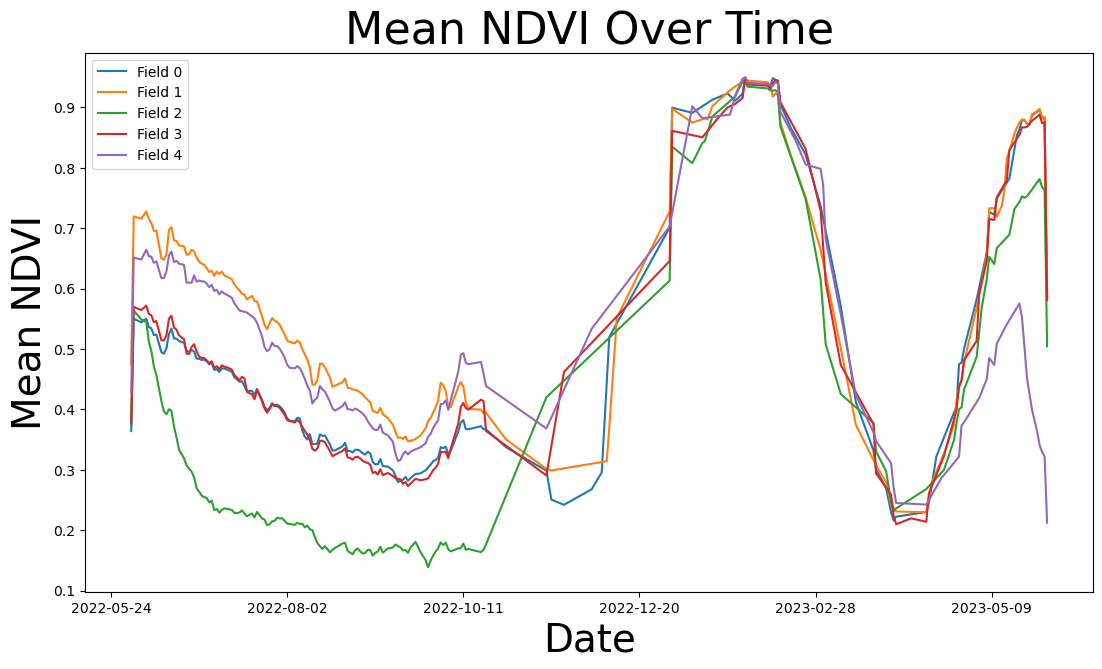

In [61]:
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(13, 7))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

# Formatting the dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Date format
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))  # Show a date every week

for idx, field_id in enumerate(agriculture_fields.index.values):

    series = ndvi_df[(ndvi_df["field_id"] == field_id) & (ndvi_df["clear"].ge(0.8))]
    
    # Non rolling average option
    # series.plot(ax=ax, x="date", y="ndvi_mean", color=f"C{idx}", label=("Field " + str(field_id)))
    
    # Rolling average option
    rolling_avg = moving_average(series["ndvi_mean"],3)
    series["rolling_avg"] = rolling_avg
    series.plot(ax=ax, x="date", y="rolling_avg", color=f"C{idx}", label=("Field " + str(field_id)))

    
title = ax.set_title('Mean NDVI Over Time', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

## 3) Visualize True Color and Calculate a Multi-Temporal Median NDVI

In this section, we will look at:

  - Requesting true color imagery over cloud free days
  - Performing multi-temporal analysis by caclulating the median NDVI from cloud-free images

To create our visualizations - let's start by selecting one field for the demonstration. In practice, you can batch these requests.

Field #0 selected


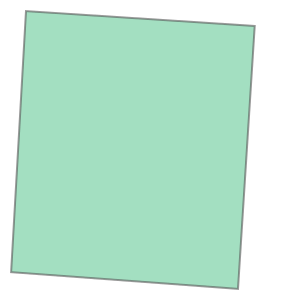

In [62]:
# Select a field index from the dataframe for our fields
# Included geojson ranges from 0 to 3
index = 0 

agriculture_field = agriculture_fields_3857.iloc[index]

print(f"Field #{index} selected")

agriculture_field["geometry"]

In the following, we identify dates that are closest to the peak NDVI value. We can use the resulting date range in a multitemporal requests to create a median value.

In [71]:
# Subset the time series to one field where it's >90% clear
one_field = ndvi_df[(ndvi_df["field_id"] == 0) & (ndvi_df["clear"].ge(0.9))]

# Find the date with the highest NDVI
peak_ndvi_date = one_field.loc[one_field['ndvi_mean'].idxmax(), 'date']

# Calculate a column for date difference from peak NDVI 
one_field['date_diff'] = (one_field['date'] - peak_ndvi_date).abs()

# Find the 5 dates where we have clear imagery closest to the peak NDVI
one_field_sorted = one_field.sort_values(by='date_diff')

unique_acquisitions = one_field_sorted.head(5).sort_values(by="date")['date']

unique_acquisitions_list = unique_acquisitions.to_list()

unique_acquisitions_list

[datetime.date(2023, 2, 9),
 datetime.date(2023, 2, 10),
 datetime.date(2023, 2, 11),
 datetime.date(2023, 2, 13),
 datetime.date(2023, 2, 14)]

Now, we can create Processing API requests for each date to visualize the imagery.

In [64]:
# Create Process API requests for each date

true_color_evalscript = """//VERSION=3
//True Color

function setup() {
    return {
      input: ["blue", "green", "red", "dataMask", "clear"],
      output: { bands: 3 }
    };
  }
  
  function evaluatePixel(sample) {
    return [sample.red / 3000, sample.green / 3000, sample.blue / 3000, sample.dataMask*sample.clear];
  }
"""

process_requests = []

time_difference = timedelta(hours=1)

for timestamp in unique_acquisitions_list:
    request = SentinelHubRequest(
        evalscript=true_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp, timestamp),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=Geometry(agriculture_field["geometry"], crs=CRS("EPSG:3857")),
        resolution=(3, 3),
        config=config,
    )
    process_requests.append(request)

print("{} Process API requests prepared!".format(len(process_requests)))
print("\nFirst request: \n")
print(json.dumps(request.payload, indent=4))

5 Process API requests prepared!

First request: 

{
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/EPSG/0/3857"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -5156676.037790387,
                            -1243448.6937833778
                        ],
                        [
                            -5154913.182334186,
                            -1243563.3835216975
                        ],
                        [
                            -5155042.201624014,
                            -1245589.520958671
                        ],
                        [
                            -5156790.696865904,
                            -1245460.529676386
                        ],
                        [
                            -5156676.037790387,
                 

In [65]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

CPU times: total: 141 ms
Wall time: 2.65 s


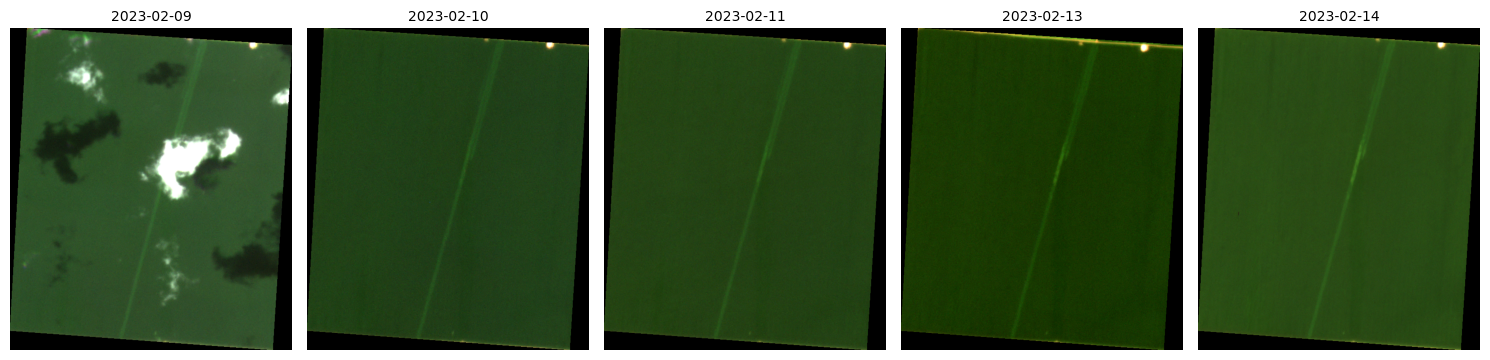

In [66]:
ncols, nrows = 5, 1

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 5),
    subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions_list)):
    ax = axis[idx]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1)) 
    ax.set_title(timestamp.isoformat(), fontsize=10)

plt.tight_layout()
plt.show()

### Create a median NDVI image over 5 nearest clear days

In [80]:
data_collection = DataCollection.define_byoc(collection_id)

input_data = SentinelHubStatistical.input_data(data_collection)

# Specify a resolution
resx = 3
resy = 3

min_date = unique_acquisitions.min()
max_date = unique_acquisitions.max()
time_interval = min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')

# Provide an evalscript to generate true color visualizations
median_ndvi_evalscript = """// Setup function defining the input/output settings

function setup() {
    return {
        input: ["red", "nir", "clear", "dataMask"],
        output: [{
            id: "default",
            bands: 4
        }
    ],
        mosaicking: "ORBIT"  // Mosaicking method
};
}

// Function to calculate NDVI
function calculateNDVI(nir, red) {
    return (nir - red) / (nir + red);
}

// Function to get the median value from an array
function getMedian(values) {
    values.sort((a, b) => a - b);
    const middle = Math.floor(values.length / 2);
    return values.length % 2 !== 0 ? values[middle] : (values[middle - 1] + values[middle]) / 2.0;
}

// Define color ramp for NDVI visualization
const colorRamp = [
    [0.0, 0xff0000],    // Red for low NDVI (0.0)
    [0.5, 0xffff00],    // Yellow for medium NDVI (0.5)
    [1.0, 0x001a00],    // Dark green for high NDVI (1.0)
];

let viz = new ColorRampVisualizer(colorRamp);

// Evaluate each pixel across all samples
function evaluatePixel(samples) {
    let ndviValues = [];

    for (let i = 0; i < samples.length; i++) {
        let sample = samples[i];
        // Only use pixels that have valid data AND are clear (not cloudy)
        if (sample.dataMask === 1 && sample.clear === 1) { 
            let ndvi = calculateNDVI(sample.nir, sample.red);
            ndviValues.push(ndvi);
        }
    }

    // If no valid pixels found, return transparent
    if (ndviValues.length === 0) {
        return [0, 0, 0, 0];
    }

    // Calculate the median NDVI
    let medianNDVI = getMedian(ndviValues);

    // Use ColorRampVisualizer to get the color
    let visVal = viz.process(medianNDVI);
    
    // Return with alpha channel
    return [...visVal, 1];

}
"""

In [ ]:


request = SentinelHubRequest(
    evalscript=median_ndvi_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_collection,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=Geometry(agriculture_field["geometry"], crs=CRS("EPSG:3857")),
    resolution=(3, 3),
    config=config,
)

image = request.get_data()

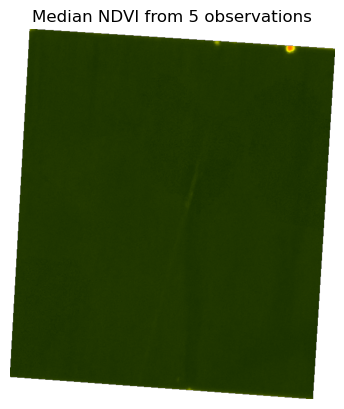

In [79]:
plt.imshow(image[0])
plt.axis('off')
plt.title("Median NDVI from 5 observations")
plt.show() 